# OVH Projet:

#### The goal of this task is to prepare statistical analysis of set of data_ovh from disks.

Each entry of the data_ovh set consists of following fields separated by `;`
character:

- `data_ovhcenter`
- `hostname`
- `disk serial`
- `disk age (in s)`
- `total reads`
- `total writes`
- `average IO latency from 5 minutes (in ms)`
- `total uncorrected read errors`
- `total uncorrected write errors`

The proper solution (a script in Python) should output following
information:

- How many disks are in total and in each DC
- Which disk is the youngest/oldest one and what is its age (in days)
- What's the average disk age per DC (in days)
- How many read/write IO/s disks processes on average
- Find top 5 disks with lowest/highest average IO/s (reads+writes, print disks and their avg IO/s)
- Find disks which are most probably broken, i.e. have non-zero uncorrected errors (print disks and error counter)

There should also be tests that verify if parts of the script are processing data_ovh properly.

-----------------------
------------------------

### Data analysis and cleaning

Let's start by reading the datasets into pandas and exploring them.

The next steps I will be to:

- Use the **`DataFrame.info()`** and **`DataFrame.head()`** methods to print information about both dataframes, as well as the first few rows.
- **`DataFrame.shape`** - to find the shape of the whole `DataFrame`.
- **`DataFrame.describe()`** (with and without **`include='all'`** to get both categorical and numeric columns).
- **`Series.value_counts()`**, **`Series.head()`**  and **`DataFrame.isnull()`** methods to explore the data and figure out some next steps, or if any columns need a closer look.

-----------------------
##### Disclaimer:

*As I do not know what is the broader context of the purpose for which I am carrying out the analysis, I decided to choose the `Pandas` library for further work. I am aware that for very large data sets it is not the fastest library. However, since the set has only 25,000 rows, I will stick to 'Pandas'.*

*In other situations, you may consider:*


- Vectorization
- Cython routines
- List Comprehensions (vanilla for loop)
- `DataFrame.apply` ():
    - 1) Reductions that can be performed in Cython, 
    - 2) Iteration in Python space
    
- `DataFrame.itertuples()` and `iteritems()`
- `DataFrame.iterrows()`

*More about it we can find [here](https://stackoverflow.com/questions/24870953/does-pandas-iterrows-have-performance-issues) and [here](https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas/55557758#55557758).*

In [1]:
import numpy as np
import pandas as pd

# The Jupyter magic %matplotlib inline allows plots to be displayed inline.
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

with open('data.raw', 'r') as file1:
    data_ovh = pd.read_csv(
        file1,
        sep=";",
        header=None
    )
    
# print(data_ovh) #test
# create a dictionary with keys and lists.

col_names_list = ['data_ovhcenter', 
    'hostname', 
    'disk serial', 
    'disk age (in s)', 
    'total reads', 
    'total writes', 
    'average I O latency from 5 minutes (in ms)', 
    'total uncorrected read errors', 
    'total uncorrected write errors']

# Camel sase for tittles in columns:
col_names_list = [
    n.title().replace(' ', '') 
    for n in col_names_list
]
# print(col) # test

data_ovh.columns = col_names_list

data_ovh.head()

,Data_Ovhcenter,Hostname,DiskSerial,DiskAge(InS),TotalReads,TotalWrites,AverageIOLatencyFrom5Minutes(InMs),TotalUncorrectedReadErrors,TotalUncorrectedWriteErrors
0,dc-fqu,host-000865.dc-fqu.storage.ovh,OQAZWMEH00,88708764,1615982187,902312187,16,0,0
1,dc-tur,host-001039.dc-tur.storage.ovh,GJJFFTWA01,3624579,2357337,31100109,20,0,0
2,dc-bzy,host-000487.dc-bzy.storage.ovh,MOBCPZSQ02,65789402,2657091964,471399188,21,0,0
3,dc-gxj,host-000801.dc-gxj.storage.ovh,USEUAPSE03,48096270,2017220839,130159678,23,0,0
4,dc-tur,host-001860.dc-tur.storage.ovh,UCXZEOND04,43085214,984311733,699974718,19,0,0


In [2]:
data_ovh.shape

(25000, 9)

In [3]:
data_ovh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 9 columns):
Data_Ovhcenter                        25000 non-null object
Hostname                              25000 non-null object
DiskSerial                            25000 non-null object
DiskAge(InS)                          25000 non-null int64
TotalReads                            25000 non-null int64
TotalWrites                           25000 non-null int64
AverageIOLatencyFrom5Minutes(InMs)    25000 non-null int64
TotalUncorrectedReadErrors            25000 non-null int64
TotalUncorrectedWriteErrors           25000 non-null int64
dtypes: int64(6), object(3)
memory usage: 1.7+ MB


Our data in the `data_ovh` data frame has 25000 entries (rows). 

Three columns are object types and have strings. 

Six columns have `int64` - in our case integers.


---------------------------------------------------------


In [4]:
data_ovh.describe()

,DiskAge(InS),TotalReads,TotalWrites,AverageIOLatencyFrom5Minutes(InMs),TotalUncorrectedReadErrors,TotalUncorrectedWriteErrors
count,2.500000e+04,2.500000e+04,2.500000e+04,25000.000000,25000.000000,25000.00000
mean,6.352039e+07,1.597572e+09,6.403327e+08,14.503040,0.000080,0.00024
std,3.036906e+07,1.147848e+09,4.555051e+08,5.005169,0.008944,0.01549
min,1.984100e+04,2.459900e+05,4.891900e+04,0.000000,0.000000,0.00000
25%,4.172478e+07,7.240661e+08,2.904965e+08,11.000000,0.000000,0.00000
50%,6.291107e+07,1.380994e+09,5.611901e+08,14.000000,0.000000,0.00000
75%,8.429411e+07,2.228170e+09,8.931261e+08,18.000000,0.000000,0.00000
max,1.791799e+08,1.006793e+10,4.181582e+09,36.000000,1.000000,1.00000


In [5]:
data_ovh.describe(include='all')

,Data_Ovhcenter,Hostname,DiskSerial,DiskAge(InS),TotalReads,TotalWrites,AverageIOLatencyFrom5Minutes(InMs),TotalUncorrectedReadErrors,TotalUncorrectedWriteErrors
count,25000,25000,25000,2.500000e+04,2.500000e+04,2.500000e+04,25000.000000,25000.000000,25000.00000
unique,5,2000,25000,NaN,NaN,NaN,NaN,NaN,NaN
top,dc-tur,host-000795.dc-tur.storage.ovh,USHOPATZ41,NaN,NaN,NaN,NaN,NaN,NaN
freq,5240,28,1,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,6.352039e+07,1.597572e+09,6.403327e+08,14.503040,0.000080,0.00024
std,NaN,NaN,NaN,3.036906e+07,1.147848e+09,4.555051e+08,5.005169,0.008944,0.01549
min,NaN,NaN,NaN,1.984100e+04,2.459900e+05,4.891900e+04,0.000000,0.000000,0.00000
25%,NaN,NaN,NaN,4.172478e+07,7.240661e+08,2.904965e+08,11.000000,0.000000,0.00000
50%,NaN,NaN,NaN,6.291107e+07,1.380994e+09,5.611901e+08,14.000000,0.000000,0.00000
75%,NaN,NaN,NaN,8.429411e+07,2.228170e+09,8.931261e+08,18.000000,0.000000,0.00000


In [6]:
"""
with `.isnull()` function I can check a scalar or 
array-like object and indicates whether values are missing 
(NaN in numeric arrays, 
None or NaN in object arrays, 
NaT in datetimelike)

with `.any()` function 
I can check for any instance in the whole df
"""
data_ovh.isnull().any()


Data_Ovhcenter                        False
Hostname                              False
DiskSerial                            False
DiskAge(InS)                          False
TotalReads                            False
TotalWrites                           False
AverageIOLatencyFrom5Minutes(InMs)    False
TotalUncorrectedReadErrors            False
TotalUncorrectedWriteErrors           False
dtype: bool

##### Data analysis and cleaning: conclusion

As the data looks consistent, as evidenced by the fact that:
- `data_ovh.isnull ()` showed that we do not have empty fields
- `data_ovh.describe (include = 'all')` and data_ovh.describe () showed that we do not have outliners

In fact, the data itself has errors, as evidenced by the fact that it has the columns `TotalUncorrectedReadErrors` and` otalUncorrectedWriteErrors`. However, these are errors that were foreseen by the creator of this database. As the values in the columns mentioned are also consistent, I can go to the next part.


--------------------------------------
Since some tasks can be solved faster than others, and the very fact of data analysis gives fragments of answers, let me focus on what comes effortlessly in the first place.

I'll start with the quests: 
- **"How many read/write IO/s disks processes on average"**
- **"Find disks which are most probably broken, i.e. have non-zero uncorrected errors (print disks and error counter)"**

----------


### How many read/write IO/s disks processes on average:

In order to find out how many read / write IO / s disks processes on average I will use the `df.describe ()` method. Additionally, I will do it on the new data frame: `data_ovh_r_w_io_per_s_avg`, which will only contain the columns that are relevant for this task.

In [7]:
"""
"How many read/write IO/s disks processes on average":
"""

data_ovh_r_w_io_per_s_avg = data_ovh[
    ['TotalReads',
     'TotalWrites',
     'AverageIOLatencyFrom5Minutes(InMs)']
]

data_ovh_r_w_io_per_s_avg.describe()

,TotalReads,TotalWrites,AverageIOLatencyFrom5Minutes(InMs)
count,2.500000e+04,2.500000e+04,25000.000000
mean,1.597572e+09,6.403327e+08,14.503040
std,1.147848e+09,4.555051e+08,5.005169
min,2.459900e+05,4.891900e+04,0.000000
25%,7.240661e+08,2.904965e+08,11.000000
50%,1.380994e+09,5.611901e+08,14.000000
75%,2.228170e+09,8.931261e+08,18.000000
max,1.006793e+10,4.181582e+09,36.000000


As we can see on avarage there is:

- For `TotalReads` **1.597572e+09**.
- For `TotalWrites` **6.403327e+08**.
- For **IO/s** in `AverageIoLatencyFrom5Minutes(InMs)` **14.503040** **Ms**.

------------

### Find disks which are most probably broken, i.e. have non-zero uncorrected errors (print disks and error counter):

In order to find disks which are most probably broken, i.e. have non-zero uncorrected errors (print disks and error counter) I will use boolean indexing.

As we can read on [geeksforgeeks.org](https://www.geeksforgeeks.org/boolean-indexing-in-pandas/):

*In boolean indexing, we will select subsets of data based on the actual values of the data in the DataFrame and not on their row / column labels or integer locations. In boolean indexing, we use a boolean vector to filter the data*

In [8]:
"""
Find disks which are most probably broken, 
i.e. have non-zero uncorrected errors (print disks and error counter):
"""

data_ovh_errors_ture = (
    data_ovh['TotalUncorrectedReadErrors'] != 0
)

print(data_ovh_errors_ture.value_counts())
print("\n", "\n")

data_ovh_errors_tuwe = (
    data_ovh['TotalUncorrectedWriteErrors'] != 0
)

print(data_ovh_errors_tuwe.value_counts())

False    24998
True         2
Name: TotalUncorrectedReadErrors, dtype: int64

 

False    24994
True         6
Name: TotalUncorrectedWriteErrors, dtype: int64


as we can see on 25,000 rows there are:

- For `TotalUncorrectedReadErrors`  **===> 2 errors**
- For `TotalUncorrectedWriteErrors` **===> 6 errors**

Disks that have `TotalUncorrectedReadErrors`:

In [9]:
data_ovh[data_ovh_errors_ture][['DiskSerial', 'TotalUncorrectedReadErrors']]

,DiskSerial,TotalUncorrectedReadErrors
3612,WFEMWTIP12,1
18924,JTGNZHJU24,1


Disks that have `TotalUncorrectedWriteErrors`:

In [10]:
data_ovh[data_ovh_errors_tuwe][['DiskSerial', 'TotalUncorrectedWriteErrors']]

,DiskSerial,TotalUncorrectedWriteErrors
8198,ERJOGZON98,1
13707,WWEKLLAQ07,1
19039,PDUACWYQ39,1
19319,DDCSTILM19,1
23998,CFBDCBWV98,1
24990,RUIWCEYE90,1


### How many disks are in total and in each DC:

**How many disks are in each DC:**

Because I assume that all disk serials are unique I can solve this task by grouping `DC`: `Data_Ovhcenter` column. Using the `size()` function I can count the instances for all disks at once.

In [11]:
"""
Just in case I will check do we have unique disk serials:
"""
a = data_ovh['DiskSerial']
a.is_unique

True

In [12]:
"""
Because each disk that I can find, will always has a unique serial number
I can check how many disks are in each DC using just `df.groupby()` with
the `size()` function. 
The `size()` function will point out serial instances for each DC group.
"""

data_ovh_disks_per_DC = (
    data_ovh.groupby('Data_Ovhcenter')
    .size()
)

data_ovh_disks_per_DC = (
    data_ovh_disks_per_DC
    .sort_values(ascending=True)
)

data_ovh_disks_per_DC

Data_Ovhcenter
dc-tug    4549
dc-bzy    4983
dc-gxj    5078
dc-fqu    5150
dc-tur    5240
dtype: int64

#### Before we jump to a conclusion about this data:

At this point, I realized that I don't know - once again - what's the purpose of this analysis (fuzzy logic). If the output data is needed for further computing, processing etc. Then, it's fine, output data are enough. But if someone wants to analyse those data, then it would be better to present them in a more human-readable format. It is important because in this manner there is easier to understand data and find some hidden patterns. More about this can be found [here](https://en.wikipedia.org/wiki/Principles_of_grouping) and [here](https://en.wikipedia.org/wiki/Gestalt_psychology).

That's why I decided to implement plots using `Matplotlib` library.

##### One more, "before", we start:

If I wanted to publish the data visualizations I create, I need to be mindful of people having [**colour blindness**](https://en.wikipedia.org/wiki/Color_blindness). Thankfully, there are colour palettes I can use that are friendly for people with colour blindness. One of them is called [Color Blind 10](http://tableaufriction.blogspot.com/2012/11/finally-you-can-use-tableau-data-colors.html) and was released by Tableau, the company that makes the data visualization platform of the same name.

**The Data-Ink concept** 

Data-ink is the non-erasable ink used for the presentation of data. If data-ink would be removed from the image, the graphic would lose the content. Non-Data-Ink is accordingly the ink that does not transport the information but is used for scales, labels and edges. The data-ink ratio is the proportion of Ink that is used to present actual data compared to the total amount of ink (or pixels) used in the entire display. 

Non-data ink includes any elements in the chart that don't directly display data points. This includes tick markers, tick labels, and legends. Data ink includes any elements that display and depending on the data points underlying the chart. In a line chart, the data-ink would primarily be the lines and in a scatter plot, the data-ink would primarily be in the markers. As I increase the data-ink ratio, I decrease non-data ink that can help a viewer understand certain aspects of the plots. I need to be mindful of this trade-off as I work on making the appearance of plots to tell a story because plots I create could end up telling the wrong story.

This principle was originally set forth by [Edward Tufte](https://en.wikipedia.org/wiki/Edward_Tufte), a pioneer in the field of data visualization. Tufte's first book, **The Visual Display of Quantitative Information**, is considered a bible among information designers.


![SegmentLocal](data-ink.gif "Non-data ink")

“Graphical excellence is that which gives to the viewer the greatest number of ideas in the shortest time with the least ink in the smallest space.”
                                                                                                     Edward Tufte

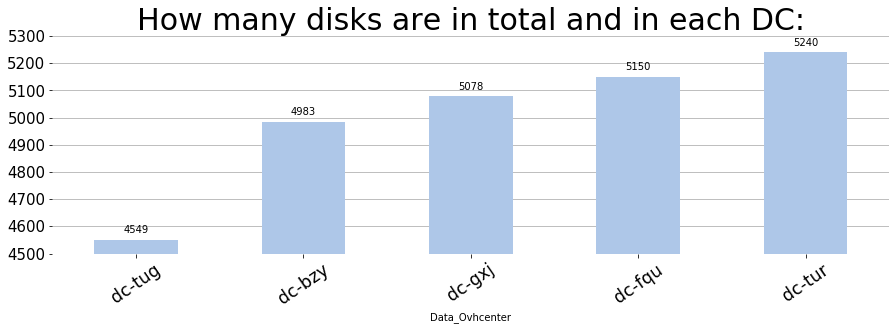

In [13]:
# let's do a plot:
fig1, ax = plt.subplots(figsize=(15,4))

"""
The axis is drawn as a unit, so the effective zorder for drawing 
the grid is determined by the zorder of each axis, 
not by the zorder of the Line2D objects comprising the grid. 
Therefore, to set grid zorder, use set_axisbelow or, 
for more control, call the set_zorder method of each axis.

Inspiration from: 
https://stackoverflow.com/questions/31506361/grid-zorder-seems-not-to-take-effect-matplotlib
"""
ax.set_axisbelow(True)

"""
for the sake of using colours from the colour-blind page: 
http://tableaufriction.blogspot.com/2012/11/finally-you-can-use-tableau-data-colors.html
I need to convert int to float between 0 and 1 for RGB values like 174.199.232 (blue colour).
The value 174.199.232 is from the mentioned page.
It is so because matplotlib needs it in such a format.

Inspired from:
https://stackoverflow.com/questions/41643189/plotting-just-a-single-rgb-color-in-matplotlib
"""
ax = data_ovh_disks_per_DC.plot.bar(
    fontsize=15,
    zorder=1,
    color=(174/255, 199/255, 232/255)
) # 'zorder' is bar layaut order

"""
Below is a for loop for displaying values above their respective bars.

Inspiration from:
https://stackoverflow.com/questions/63146552/how-do-i-display-these-values-above-their-respective-bars-on-this-bar-chart-with
"""
for p in ax.patches:
    ax.annotate(s=p.get_height(),
                xy=(p.get_x()+p.get_width()/2.,
                    p.get_height()
                   ),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points')


ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)

ax.set_title(
    'How many disks are in total and in each DC:',
    fontsize=30
)

ax.set_xticklabels(
    data_ovh_disks_per_DC.index,
    rotation=34.56789,
    fontsize='xx-large'
) # We will set xticklabels in angle to be easier to read)
# The labels are centred horizontally, so when we rotate them 34.56789°

ax.grid(axis='y', zorder=0) # 'zorder' is bar layaut order

plt.ylim([4500, 5300])

plt.show()

As we can see:
- `dc-tug` has the lowest quantity of drives, having **4549** units
- `dc-tur` has the highest quantity of drives, having **5240** units

--------


**How many disks are in total:**

Because each disk that I can find, will always has a unique serial number, in consequence, row numbers will be equal to the number of disks. Besides the fact that at the beginning I compute it with `df.describe()` function. I will print below the 

In [14]:
data_ovh_disks_per_DC.sum()

25000

----------------------
### Which disk is the youngest/oldest one and what is its age (in days):

To solve this task I will use `pandas` Series.min and Series.max methods.
Because I need to know the output in days, instead of seconds, I will divide the output by 86400 which is 24 hours multiplied by 60 seconds multiplied by 60 minutes. I.e. seconds * minutes * hours = day.

In [15]:
# #test:
# print("data_ovh['DiskAge(InS)'].min() ====>", data_ovh['DiskAge(InS)'].min())

youngest_drive_age = (
    data_ovh['DiskAge(InS)']
    .min() 
    / 86400 # conversion from sec to days
)

print(
    "`youngest_drive_age` has:",
    round(youngest_drive_age,4),
    "days"
)

`youngest_drive_age` has: 0.2296 days


In [16]:
# #test:
# print("data_ovh['DiskAge(InS)'].max() ====> ", data_ovh['DiskAge(InS)'].max())

oldest_drive_age = (
    data_ovh['DiskAge(InS)']
    .max()
    / 86400 # conversion from sec to days
)

print(
    "`oldest_drive_age` has:",
    round(oldest_drive_age, 4),
    "days"
)

`oldest_drive_age` has: 2073.8416 days


In [17]:
youngest_drive_val = data_ovh['DiskAge(InS)'].min()
oldest_drive_val = data_ovh['DiskAge(InS)'].max()

youngest_drive = data_ovh.loc[
    data_ovh['DiskAge(InS)'] == youngest_drive_val,
    ['DiskSerial']
]

oldest_drive = data_ovh.loc[
    data_ovh['DiskAge(InS)'] == oldest_drive_val,
    ['DiskSerial']
]

younges_oldest_drives = pd.concat(
    [youngest_drive, oldest_drive],
    keys=['youngest drive', 'oldest drive'],
    names=['type', 'Index']
)

"""
At this point, it would be nice to have one index, 
so I need to reshape the multi-index.

Inspiration from:
https://stackoverflow.com/questions/20110170/turn-pandas-multi-index-into-column
"""
younges_oldest_drives = younges_oldest_drives.reset_index()  

"""
I need to first `round()` values before I will convert them to `int`. 
Without that the value will be rounded less accurate.
"""

younges_oldest_days_list = [
    round(youngest_drive_age, 0),
    round(oldest_drive_age, 0)
]

younges_oldest_drives['age (in days)'] = younges_oldest_days_list

younges_oldest_drives['age (in days)'] = (
    younges_oldest_drives['age (in days)']
    .astype(int)
)

younges_oldest_drives

,type,Index,DiskSerial,age (in days)
0,youngest drive,5899,WHEJNKGW99,0
1,oldest drive,14418,HBWRKAXG18,2074


In [18]:
print("2074 days it's", round(oldest_drive_age / 365, 2), "years")

2074 days it's 5.68 years


As we can see, the difference between the youngest and the oldest disc is significant.
When averaging the result over the days, the difference between the disks is 2,074 days.
It's more than five and a half years: **5.68** years.

Youngest drive has index: `5899`, serial number: **`WHEJNKGW99`** and less than one day running.

Oldest drive has index: `14418 	`, serial number: **`HBWRKAXG18`** and `2074` days.

### What's the average disk age per DC (in days)

This case is similar to previous: *How many disks are in total and in each DC*. I will use `df.groupby()` function too.

After that I will create a new **series** called `disk_avg_age` from this grouped **data frame** called `data_ovh_grouped`, I will use it for further computing with the `Series.mean()` function on 'DiskAge(InS)' column. 

Finally, `disk_avg_age` series will output the mean disk age, rounded with `round()` function and convert from seconds to days, thanks for my previous approach. 

In [19]:
data_ovh_grouped = data_ovh.groupby('Data_Ovhcenter')

# data_ovh_grouped.head() # Test

disk_avg_age = round(
    data_ovh_grouped['DiskAge(InS)'].mean() / 86400,
    0
) # conversion from sec to days

disk_avg_age = (
    disk_avg_age
    .sort_values(ascending=True)
    .astype(int)
)

disk_avg_age

Data_Ovhcenter
dc-fqu    728
dc-tug    731
dc-gxj    737
dc-tur    738
dc-bzy    741
Name: DiskAge(InS), dtype: int32

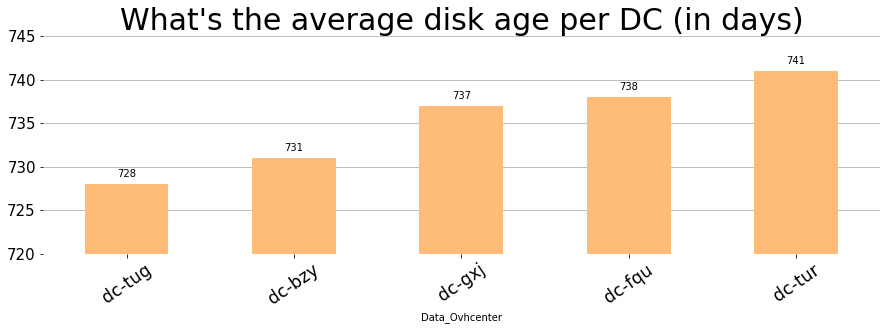

In [20]:
# let's do a plot:
fig2, ax = plt.subplots(figsize=(15,4))

"""
The axis is drawn as a unit, so the effective zorder for drawing 
the grid is determined by the zorder of each axis, 
not by the zorder of the Line2D objects comprising the grid. 
Therefore, to set grid zorder, use set_axisbelow or, 
for more control, call the set_zorder method of each axis.

Inspiration from: 
https://stackoverflow.com/questions/31506361/grid-zorder-seems-not-to-take-effect-matplotlib
"""
ax.set_axisbelow(True)

"""
for the sake of using colours from the colour-blind page: 
http://tableaufriction.blogspot.com/2012/11/finally-you-can-use-tableau-data-colors.html
I need to convert int to float between 0 and 1 for RGB values like 255.187.120 (orange colour).
The value 174.199.232 is from the mentioned page.
It is so because matplotlib needs it in such a format.

Inspired from:
https://stackoverflow.com/questions/41643189/plotting-just-a-single-rgb-color-in-matplotlib
"""
ax = disk_avg_age.plot.bar(
    fontsize=15,
    zorder=1,
    color=(255/255, 187/255, 120/255)
) # 'zorder' is bar layaut order


"""
Below is a for loop for displaying values above their respective bars.

Inspiration from:
https://stackoverflow.com/questions/63146552/how-do-i-display-these-values-above-their-respective-bars-on-this-bar-chart-with
"""
for p in ax.patches:
    ax.annotate(s=p.get_height(),
                xy=(p.get_x()+p.get_width()/2.,
                    p.get_height()
                   ),
                ha='center',
                va='center',
                xytext=(0, 10),
                textcoords='offset points'
               )

ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)

ax.set_title(
    "What's the average disk age per DC (in days)",
    fontsize=30
)

ax.set_xticklabels(
    data_ovh_disks_per_DC.index,
    rotation=34.56789,
    fontsize='xx-large'
) # We will set xticklabels in angle to be easier to read)
# The labels are centred horizontally, so when we rotate them 34.56789°

ax.grid(axis='y', zorder=0) # 'zorder' is bar layaut order

plt.ylim([720, 745])

plt.show()

### Find the top 5 disks with the lowest/highest average IO/s (reads+writes, print disks and their avg IO/s):

For this task, I can use `nsmallest()` and `nlargest()` functions on `AverageIOLatencyFrom5Minutes(InMs)` column. Additionally, I will pass `5` argument inside each function, to find all the top 5 disks from both categories: highest and lowest.

In [21]:
top_five_io_hi = (
    data_ovh['AverageIOLatencyFrom5Minutes(InMs)']
    .nlargest(5)
)
top_five_io_hi

16382    36
2854     34
3126     33
6428     33
12355    33
Name: AverageIOLatencyFrom5Minutes(InMs), dtype: int64

In [22]:
top_five_io_lo = (
    data_ovh['AverageIOLatencyFrom5Minutes(InMs)']
    .nsmallest(5)
)
top_five_io_lo

600     0
1231    0
2036    0
2956    0
3050    0
Name: AverageIOLatencyFrom5Minutes(InMs), dtype: int64

In [23]:
"""
I will use `.index` method, 
because without it I will lose index pre-column 
which may be important for someone.
"""

top_five_io_hi_df = (
    data_ovh.loc[top_five_io_hi.index]
    [[
        'TotalReads',
        'TotalWrites',
        'DiskSerial',
        'AverageIOLatencyFrom5Minutes(InMs)'
    ]]
)

top_five_io_hi_df

,TotalReads,TotalWrites,DiskSerial,AverageIOLatencyFrom5Minutes(InMs)
16382,929496345,322681613,XOPTKGIK82,36
2854,1584947146,1315972763,ZODHQRJF54,34
3126,964657074,521702727,TOFYBLXN26,33
6428,1343700381,1232961027,TUDFFJTQ28,33
12355,2864069884,2086728629,CPRRJUUE55,33


In [24]:
"""
I will use `.index` method, 
because without it I will lose index pre-column 
which may be important for someone.
"""
top_five_io_lo_df = (
    data_ovh.loc[top_five_io_lo.index]
    [[
        'TotalReads',
        'TotalWrites',
        'DiskSerial',
        'AverageIOLatencyFrom5Minutes(InMs)'
    ]]
)    

top_five_io_lo_df

,TotalReads,TotalWrites,DiskSerial,AverageIOLatencyFrom5Minutes(InMs)
600,217049438,74129008,EKWWNQWY00,0
1231,3596037290,1340676895,QUAOQMLV31,0
2036,770395321,195804561,KRCGOWUR36,0
2956,406305266,558140490,DTBBAVZV56,0
3050,1796796026,827402410,UEPGNGBN50,0


`top_five_io_lo` doesn't seem to be correct because even ram doesn't have `0ms` latency. If I assume that `0` is an outliner then I need to drop all rows with the `0` value in `AverageIOLatencyFrom5Minutes(InMs)` to find the top 5 disks with the lowest average IO/s. **This issue has to be addressed because without information about disks specification I don't know for sure is 1ms a proper lowest value that should be set in boolean comparison.**
 
In the updated approach, I will chain the `where` method with the `lambda x: x > 0`, with that I will look for the smallest values using `nsmallest()`.

If disks documentation will point out that for example, the lowest possible latency is `10 ms`, then I will change `lambda x: x > 0` to `lambda x: x > 10`.


Finally, there should be addressed a question: is the fact of having `AverageIOLatencyFrom5Minutes(InMs)` == 0 isn't a hidden bug. Maybe those rows should be dropped? Maybe it should be addressed to some support or HQ? 
Also, it should be investigated what happens with those disks. [**Some `black box` and `white box` testing**](https://www.practitest.com/qa-learningcenter/resources/black-box-vs-white-box-testing/) may be required. 


In [25]:
top_five_io_lo_no_zero = (
    data_ovh['AverageIOLatencyFrom5Minutes(InMs)']
    .where(lambda x: x > 0)
    .nsmallest(5)
)

top_five_io_lo_no_zero

27     1.0
125    1.0
153    1.0
199    1.0
586    1.0
Name: AverageIOLatencyFrom5Minutes(InMs), dtype: float64

In [26]:
"""
I will use `.index` method, 
because without it I will lose index pre-column 
which may be important for someone.
"""
top_five_io_lo_df = (
    data_ovh.loc[top_five_io_lo_no_zero.index]
    [[
        'TotalReads',
        'TotalWrites',
        'DiskSerial',
        'AverageIOLatencyFrom5Minutes(InMs)'
    ]]
)

top_five_io_lo_df

,TotalReads,TotalWrites,DiskSerial,AverageIOLatencyFrom5Minutes(InMs)
27,2863043970,570903321,YDULXDKS27,1
125,1296705465,523137947,YUZDPMNK25,1
153,1074585753,605343189,LVIICXKU53,1
199,3125488019,1119451038,LNFGSHDJ99,1
586,576612094,482145238,TINJVQDZ86,1


##### Below a list of potential outliners with `AverageIOLatencyFrom5Minutes(InMs) == 0`:

In [27]:
suspected_io_with_zero = (
    data_ovh[data_ovh['AverageIOLatencyFrom5Minutes(InMs)'] == 0]
)

suspected_io_with_zero.head()

,Data_Ovhcenter,Hostname,DiskSerial,DiskAge(InS),TotalReads,TotalWrites,AverageIOLatencyFrom5Minutes(InMs),TotalUncorrectedReadErrors,TotalUncorrectedWriteErrors
600,dc-gxj,host-001572.dc-gxj.storage.ovh,EKWWNQWY00,8299870,217049438,74129008,0,0,0
1231,dc-fqu,host-001019.dc-fqu.storage.ovh,QUAOQMLV31,92081815,3596037290,1340676895,0,0,0
2036,dc-bzy,host-001341.dc-bzy.storage.ovh,KRCGOWUR36,83742225,770395321,195804561,0,0,0
2956,dc-tug,host-001469.dc-tug.storage.ovh,DTBBAVZV56,28624016,406305266,558140490,0,0,0
3050,dc-tur,host-001931.dc-tur.storage.ovh,UEPGNGBN50,87488586,1796796026,827402410,0,0,0


In [28]:
suspected_io_with_zero.size

378

In [29]:
suspected_io_with_zero_table = pd.pivot_table(
    suspected_io_with_zero,
    values='DiskSerial',
    index='Data_Ovhcenter',
    aggfunc=np.size
)

suspected_io_with_zero_table

,DiskSerial
Data_Ovhcenter,
dc-bzy,9
dc-fqu,7
dc-gxj,7
dc-tug,9
dc-tur,10


I found 378 instances where `['AverageIOLatencyFrom5Minutes(InMs)'] == 0`.

Most instances are located in `Data_Ovhcenter`: `dc-tur` but they are in each `Data_Ovhcenter`!

--------------------------- 
I found that the Average IO latency from 5 minutes(In Ms) is from 0 (or 1) to 36 `Ms`. 

It is possible that further investigation has to be made with outliers.

### Final conclusions:

To present a bigger picture from this analysis, I will displat plots from several parts of this whole project.

I will also create a new data frame called `final_data_frame` with columns listed below:
- 'disk avg age(days)'
- 'data ovh disks per DC'
- 'top_five_io_lo_series_new'
- 'top_five_io_hi_series_new'
- 'data_ovh_disks_per_DC'

With all of that I will be able to see easily all the data.

In [30]:
top_five_io_hi_df_new = (
    data_ovh.loc[top_five_io_hi_df.index]
    [['Data_Ovhcenter', 'AverageIOLatencyFrom5Minutes(InMs)']]
)

top_five_io_hi_df_new = (
    top_five_io_hi_df_new
    .set_index('Data_Ovhcenter')
)

"""
I can then use df.squeeze() to convert the DataFrame into a Series:
"""
top_five_io_hi_series_new = top_five_io_hi_df_new.squeeze() 

top_five_io_hi_series_new

Data_Ovhcenter
dc-bzy    36
dc-tur    34
dc-fqu    33
dc-tur    33
dc-gxj    33
Name: AverageIOLatencyFrom5Minutes(InMs), dtype: int64

In [31]:
"""
let's groupby output:
"""
top_five_io_hi_series_new = (
    top_five_io_hi_series_new
    .groupby(level=0)
    .mean()
)

top_five_io_hi_series_new

Data_Ovhcenter
dc-bzy    36.0
dc-fqu    33.0
dc-gxj    33.0
dc-tur    33.5
Name: AverageIOLatencyFrom5Minutes(InMs), dtype: float64

In [32]:
top_five_io_lo_df_new = (
    data_ovh.loc[top_five_io_lo_df.index]
    [['Data_Ovhcenter', 'AverageIOLatencyFrom5Minutes(InMs)']]
)

top_five_io_lo_df_new = (
    top_five_io_lo_df_new
    .set_index('Data_Ovhcenter')
)


"""
I can then use df.squeeze() to convert the DataFrame into a Series:
"""
top_five_io_lo_series_new = top_five_io_lo_df_new.squeeze() 

top_five_io_lo_series_new

Data_Ovhcenter
dc-bzy    1
dc-fqu    1
dc-gxj    1
dc-gxj    1
dc-gxj    1
Name: AverageIOLatencyFrom5Minutes(InMs), dtype: int64

In [33]:
"""
let's groupby output:
"""
top_five_io_lo_series_new = (
    top_five_io_lo_series_new
    .groupby(level=0)
    .mean()
)

top_five_io_lo_series_new

Data_Ovhcenter
dc-bzy    1
dc-fqu    1
dc-gxj    1
Name: AverageIOLatencyFrom5Minutes(InMs), dtype: int64

In [34]:
d = {
    'disk avg age(days)': disk_avg_age,
    'data ovh disks per DC': data_ovh_disks_per_DC,
    'top_five_io_lo_series_new': top_five_io_lo_series_new,
    'top_five_io_hi_series_new': top_five_io_hi_series_new,
    'data_ovh_disks_per_DC': data_ovh_disks_per_DC
}

final_data_frame = pd.DataFrame(data=d)
final_data_frame

,disk avg age(days),data ovh disks per DC,top_five_io_lo_series_new,top_five_io_hi_series_new,data_ovh_disks_per_DC
dc-bzy,741,4983,1.0,36.0,4983
dc-fqu,728,5150,1.0,33.0,5150
dc-gxj,737,5078,1.0,33.0,5078
dc-tug,731,4549,NaN,NaN,4549
dc-tur,738,5240,NaN,33.5,5240


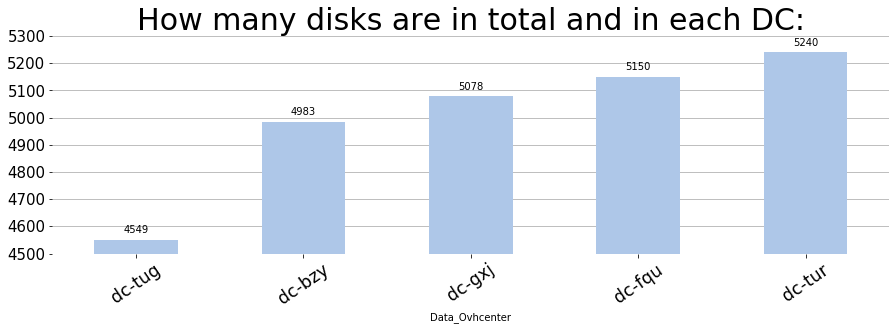

In [35]:
fig1

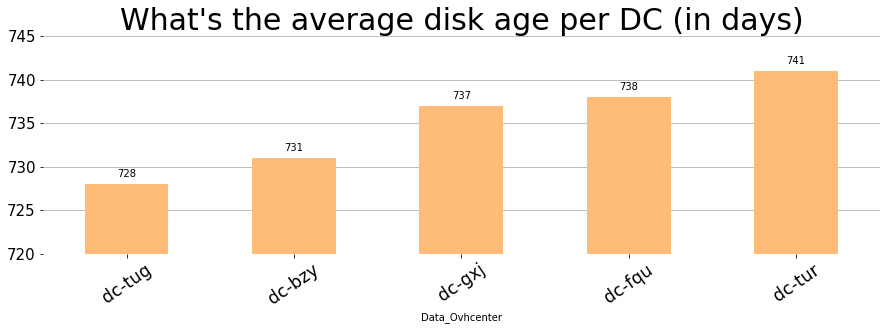

In [36]:
fig2

From the collected data I can see that:

- `dc-tur` has the highest quantity of disks from all `Data_Ovhcenter`. It also has the oldest disks. 


- `dc-tug` has the lowest quantity of disks among all `Data_Ovhcenter`. It also has the youngest disks. Because the `dc-tug` is the youngest, I assume, that it's the reason why I don't have information about values in columns: `top_five_io_lo_series_new` and `top_five_io_hi_series_new`.


- `dc-bzy` has the highest latency in `top_five_io_hi_series_new`. That's odd because it's almost the youngest, so it's possible that there is a need for some revision in the whole system. Something might be wrong with efficiency there. I suggest doing some [**`black box` and `white box` testing**](https://www.practitest.com/qa-learningcenter/resources/black-box-vs-white-box-testing/). 

In [37]:
"""
Thank you for your attention. 
Below, an easter egg running in Jupyter Notebook 
(using an open-source library that I wrote. More details at: https://pypi.org/project/get-gifNimage/ )
"""

# # !pip install get-gifNimage  | grep -v 'already satisfied'

# import get_gifNimage
# from get_gifNimage import get_gifNimage
# get_gifNimage('https://media.giphy.com/media/W80Y9y1XwiL84/giphy.gif')

'\nThank you for your attention. \nBelow, an easter egg running in Jupyter Notebook \n(using an open-source library that I wrote. More details at: https://pypi.org/project/get-gifNimage/ )\n'